<a href="https://colab.research.google.com/github/GVSU-CIS635/GVSU-CIS635-Project-Team-Data_Alliance/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from statistics import mean, stdev

In [4]:
df_streamflow = pd.read_csv('streamflow.csv', header = 0, names = ['id','year','month','day','date','q(m3/s)'])
display(df_streamflow.head())
print('\nThis dataset contains', df_streamflow.shape[0], 'rows and', df_streamflow.shape[1], 'columns')

,id,year,month,day,date,q(m3/s)
0,11963,1967,1,1,1967-01-01,2690.0
1,11964,1967,1,2,1967-01-02,2650.0
2,11965,1967,1,3,1967-01-03,2650.0
3,11966,1967,1,4,1967-01-04,2610.0
4,11967,1967,1,5,1967-01-05,2570.0



This dataset contains 18628 rows and 6 columns


In [8]:
#Attribute Classification
Categorical = ['id','year','month','day','date']
Numeric = ['q(m3/s)']

#Identify duplicates and drop them
duplication = df_streamflow[df_streamflow.duplicated(keep=False)]
print(f"df_streamflow dataframe has {duplication.shape[0]} duplicated samples.")

# df_streamflow.drop_duplicates()

df_streamflow dataframe has 0 duplicated samples.


In [7]:
#Exploratory Data Analysis
df_streamflow.info()

#print descriptive statisics
display(df_streamflow.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18628 non-null  int64  
 1   year     18628 non-null  int64  
 2   month    18628 non-null  int64  
 3   day      18628 non-null  int64  
 4   date     18628 non-null  object 
 5   q(m3/s)  18040 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 873.3+ KB


,id,year,month,day,q(m3/s)
count,18628.000000,18628.00000,18628.000000,18628.000000,18040.000000
mean,21276.500000,1992.00000,6.522869,15.729815,10671.594654
std,5377.584743,14.72017,3.448812,8.800403,14275.949377
min,11963.000000,1967.00000,1.000000,1.000000,182.840000
25%,16619.750000,1979.00000,4.000000,8.000000,1419.000000
50%,21276.500000,1992.00000,7.000000,16.000000,3060.000000
75%,25933.250000,2005.00000,10.000000,23.000000,15300.000000
max,30590.000000,2017.00000,12.000000,31.000000,79059.000000


In [9]:
#Identify missing values
df_streamflow[df_streamflow.columns].isin([np.NaN]).sum().sort_values(ascending = False)

q(m3/s)    588
id           0
year         0
month        0
day          0
date         0
dtype: int64

<ipython-input-10-7bfc5d746ffc>:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


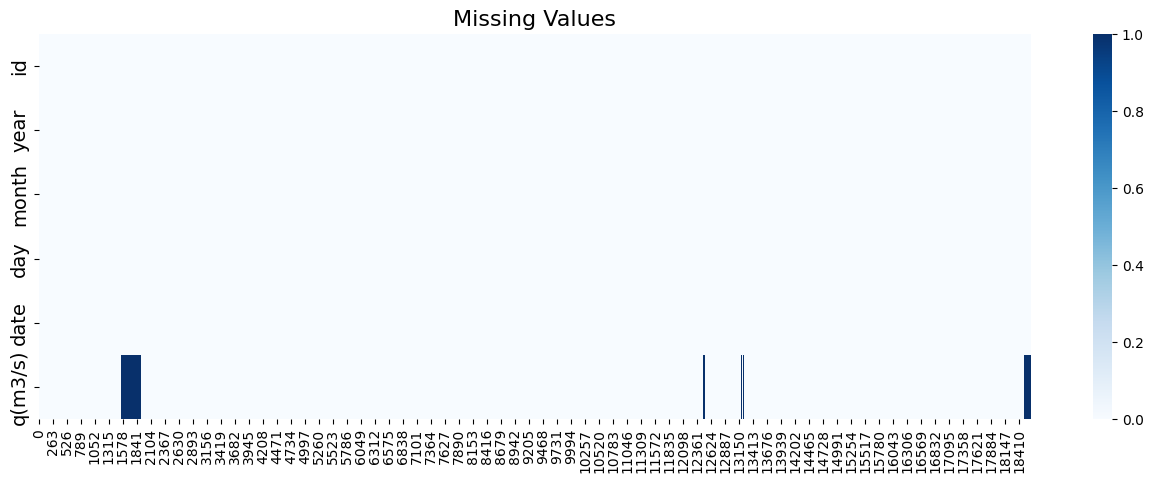

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

#view missing values in a graph
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_streamflow.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Text(0, 0.5, 'Q (m3/s)')

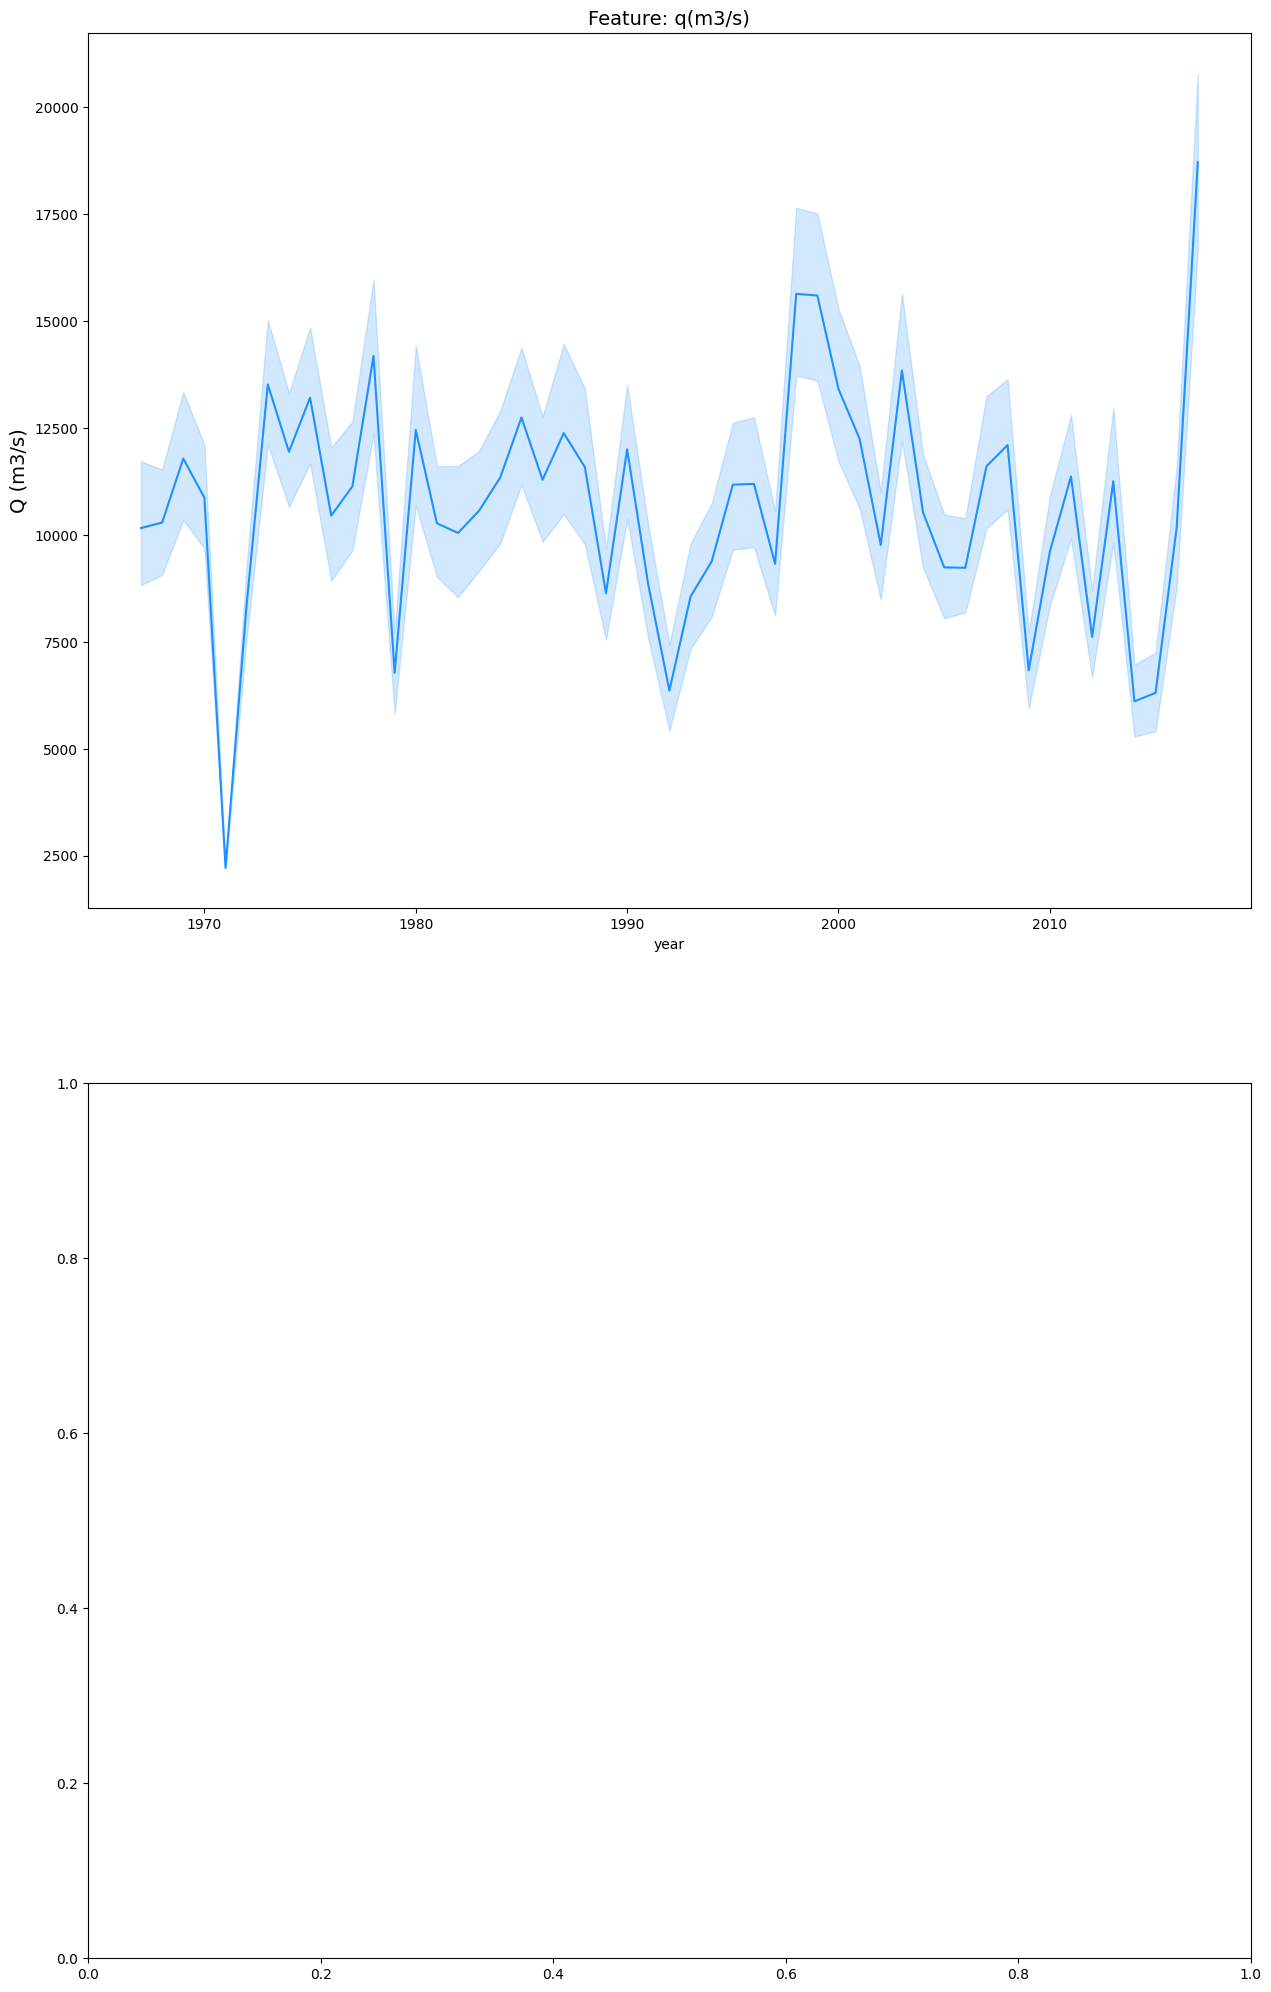

In [21]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 25))

sns.lineplot(x=df_streamflow['year'], y=df_streamflow['q(m3/s)'].fillna(method='ffill'), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: {}'.format('q(m3/s)'), fontsize=14)
ax[0].set_ylabel(ylabel= 'Q (m3/s)', fontsize=14)

In [ ]:
df_streamflow['date'] = pd.to_datetime(df_streamflow['date'])

#Replace missing values with median value
median_imputer = SimpleImputer(missing_values=np.NaN,strategy='median')

df_streamflow['q(m3/s)'] = median_imputer.fit_transform(df_streamflow[['q(m3/s)']])
display(df_streamflow)

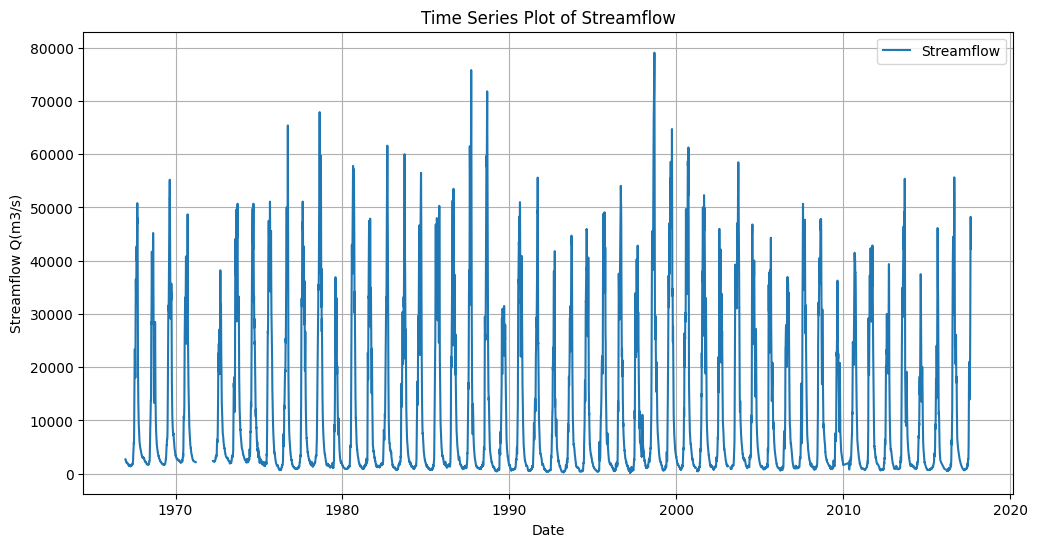

In [14]:
# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(df_streamflow['date'], df_streamflow['q(m3/s)'], label='Streamflow')
plt.title('Time Series Plot of Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow Q(m3/s)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Set 'Date' as the index for time series analysis
df_streamflow.set_index('date', inplace=True)

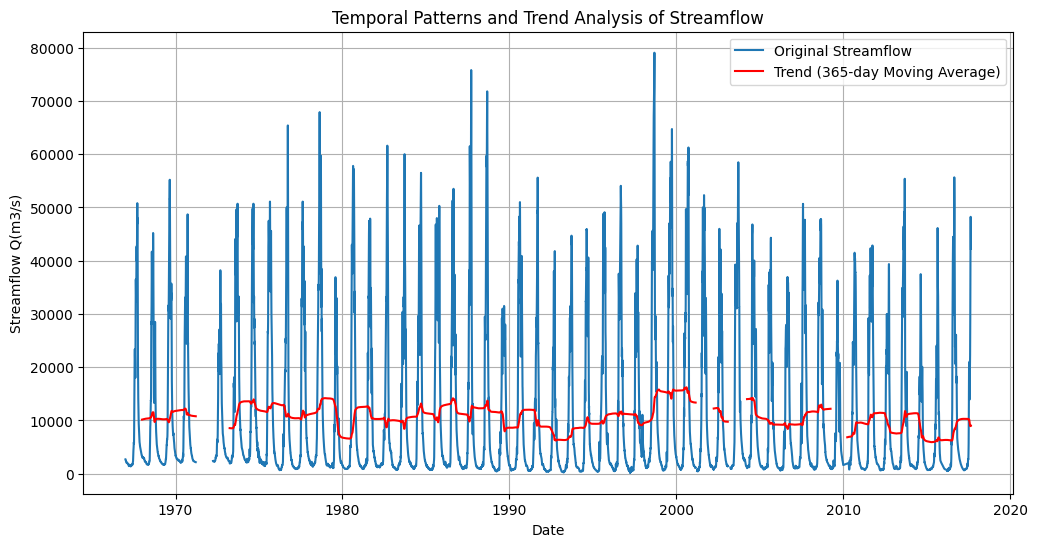

In [18]:
# Explore overall trend using a rolling mean (moving average)
rolling_mean = df_streamflow['q(m3/s)'].rolling(window=365).mean()  # 365-day moving average for annual trend
trend_df = pd.DataFrame({'Streamflow': df_streamflow['q(m3/s)'], 'Trend': rolling_mean})

# Plot the original streamflow and the trend
plt.figure(figsize=(12, 6))
plt.plot(df_streamflow.index, df_streamflow['q(m3/s)'], label='Original Streamflow')
plt.plot(trend_df.index, trend_df['Trend'], label='Trend (365-day Moving Average)', color='red')
plt.title('Temporal Patterns and Trend Analysis of Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow Q(m3/s)')
plt.legend()
plt.grid(True)
plt.show()

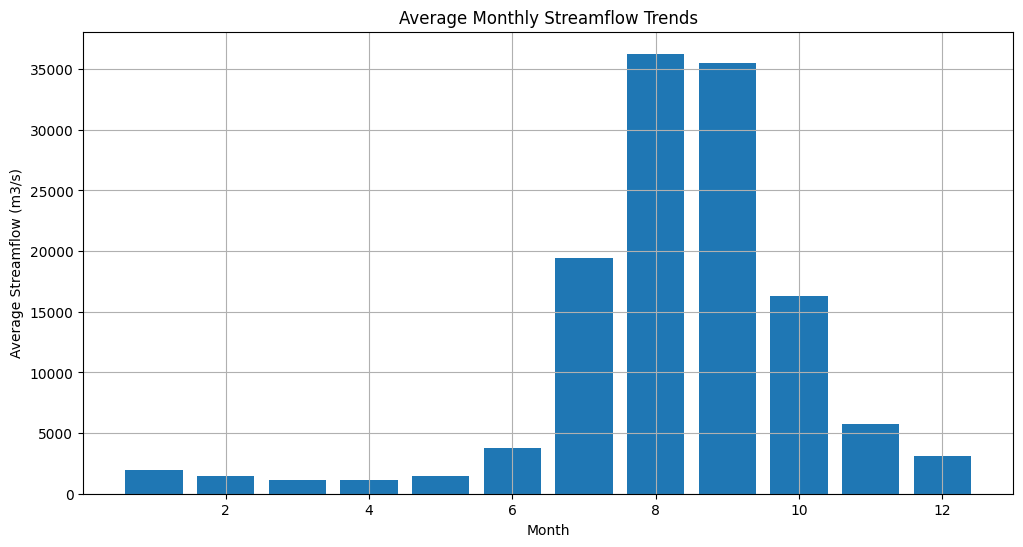

In [19]:
# Explore trends in different months
monthly_trends = df_streamflow.groupby(df_streamflow.index.month)['q(m3/s)'].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.bar(monthly_trends.index, monthly_trends.values)
plt.title('Average Monthly Streamflow Trends')
plt.xlabel('Month')
plt.ylabel('Average Streamflow (m3/s)')
plt.grid(True)
plt.show()

In [ ]:
X = df_streamflow.iloc[:, 0:4]
y = df_streamflow.iloc[:, 4:5]

# kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# model = LogisticRegression()
# lst_accuracy_scores = []

from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 46)

# for train_index, test_index in kfold.split(X, y):
#     print(train_index)
#     print(test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model.fit(X_train, y_train)
#     score = model.score(X_test, y_test)
#     lst_accuracy_scores.append(score)

# print('List of possible accuracy:', lst_accuracy_scores)
# print('\nMaximum Accuracy that can be obtained from this model is:',max(lst_accuracy_scores)*100, '%')
# print('\nMinimum Accuracy:', min(lst_accuracy_scores)*100, '%')
# print('\nOverall Accuracy:', mean(lst_accuracy_scores)*100, '%')
# print('\nStandard Deviation is:', stdev(lst_accuracy_scores))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

models = []

models.append(("KNN Classifier", KNeighborsClassifier(n_neighbors=5)))
models.append(("Decision Tree Classifier", DecisionTreeClassifier()))
models.append(("Random Forest Classifier", RandomForestClassifier(n_estimators=10, random_state=42)))
models.append(("Adaboost Classifier", AdaBoostClassifier(n_estimators=10, random_state=42)))
models.append(("Naive Baiyes Classifier", GaussianNB()))

for name, model in models:
  model.fit(X_train, y_train)
  accuracy = accuracy_score(y_test, model.predict(X_test))
  print("\n", name, "Accuracy:", accuracy * 100.0, '%')

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



 KNN Classifier Accuracy: 0.0 %
